## Zillow

For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.

You will have a zillow.ipynb file and a helper file for each section in the pipeline.

### acquire & summarize
1. Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.

- Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
- Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction.
- Only include properties that include a latitude and longitude value.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import os
from env import host, username, password

In [2]:
##### DB CONNECTION #####
def get_db_url(db, username=username, host=host, password=password):
    
    return f'mysql+pymysql://{username}:{password}@{host}/{db}'

##### ACQUIRE ZILLOW #####
def new_zillow_data():
    '''
    gets zillow information from CodeUp db using SQL query
    and creates a dataframe
    '''

    # SQL query
    zillow_query = '''SELECT *
                        FROM properties_2017 prop
                        INNER JOIN (SELECT parcelid, max(logerror) AS logerror, max(transactiondate) AS transactiondate
                                    FROM predictions_2017
                                    GROUP BY parcelid) pred USING (parcelid)
                        LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
                        LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
                        LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
                        LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid)
                        LEFT JOIN propertylandusetype land USING (propertylandusetypeid)
                        LEFT JOIN storytype story USING (storytypeid)
                        LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid)
                        LEFT JOIN unique_properties special USING (parcelid)
                        WHERE prop.latitude IS NOT NULL 
                        AND prop.longitude IS NOT NULL
                        AND transactiondate LIKE '2017%'
                    '''
    
    # reads SQL query into a DataFrame            
    df = pd.read_sql(zillow_query, get_db_url('zillow'))
    
    return df

def get_zillow_data():
    '''
    checks for existing csv file
    loads csv file if present
    if there is no csv file, calls new_zillow_data
    '''
    
    if os.path.isfile('zillow.csv'):
        
        df = pd.read_csv('zillow.csv', index_col=0)
        
    else:
        
        df = new_zillow_data()
        
        df.to_csv('zillow.csv')
    
    return df

In [3]:
df = get_zillow_data()
df.head()

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,nan,nan,261.00,nan,nan,nan,nan,1727539,nan,...,"60,590,630,072,012.00",0.03,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,17052889,nan,nan,261.00,nan,nan,nan,nan,1387261,nan,...,"61,110,010,023,006.00",0.06,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,14186244,nan,nan,261.00,nan,nan,nan,nan,11677,nan,...,"60,590,218,022,012.00",0.01,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,12177905,nan,nan,261.00,2.00,nan,nan,nan,2288172,nan,...,"60,373,001,001,006.00",-0.10,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,10887214,nan,nan,266.00,2.00,nan,nan,1.00,1970746,nan,...,"60,371,236,012,000.00",0.01,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [4]:
df.shape

(77380, 68)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77380 entries, 0 to 77379
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77380 non-null  int64  
 1   typeconstructiontypeid        222 non-null    float64
 2   storytypeid                   50 non-null     float64
 3   propertylandusetypeid         77380 non-null  float64
 4   heatingorsystemtypeid         49439 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   architecturalstyletypeid      206 non-null    float64
 7   airconditioningtypeid         24953 non-null  float64
 8   id                            77380 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77380 non-null  float64
 11  bedroomcnt                    77380 non-null  float64
 12  buildingqualitytypeid         49671 non-null  float64
 13  c

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,"77,380.00","13,007,149.52","3,481,368.13","10,711,855.00","11,538,296.75","12,531,548.50","14,211,843.75","167,689,317.00"
typeconstructiontypeid,222.00,6.04,0.56,4.00,6.00,6.00,6.00,13.00
storytypeid,50.00,7.00,0.00,7.00,7.00,7.00,7.00,7.00
propertylandusetypeid,"77,380.00",261.83,5.14,31.00,261.00,261.00,266.00,275.00
heatingorsystemtypeid,"49,439.00",3.92,3.59,1.00,2.00,2.00,7.00,24.00
buildingclasstypeid,15.00,3.93,0.26,3.00,4.00,4.00,4.00,4.00
architecturalstyletypeid,206.00,7.39,2.73,2.00,7.00,7.00,7.00,21.00
airconditioningtypeid,"24,953.00",1.81,2.97,1.00,1.00,1.00,1.00,13.00
id,"77,380.00","1,495,126.49","860,905.69",349.00,"752,050.00","1,497,870.00","2,240,480.25","2,982,274.00"
basementsqft,50.00,679.72,689.70,38.00,273.00,515.00,796.50,"3,560.00"


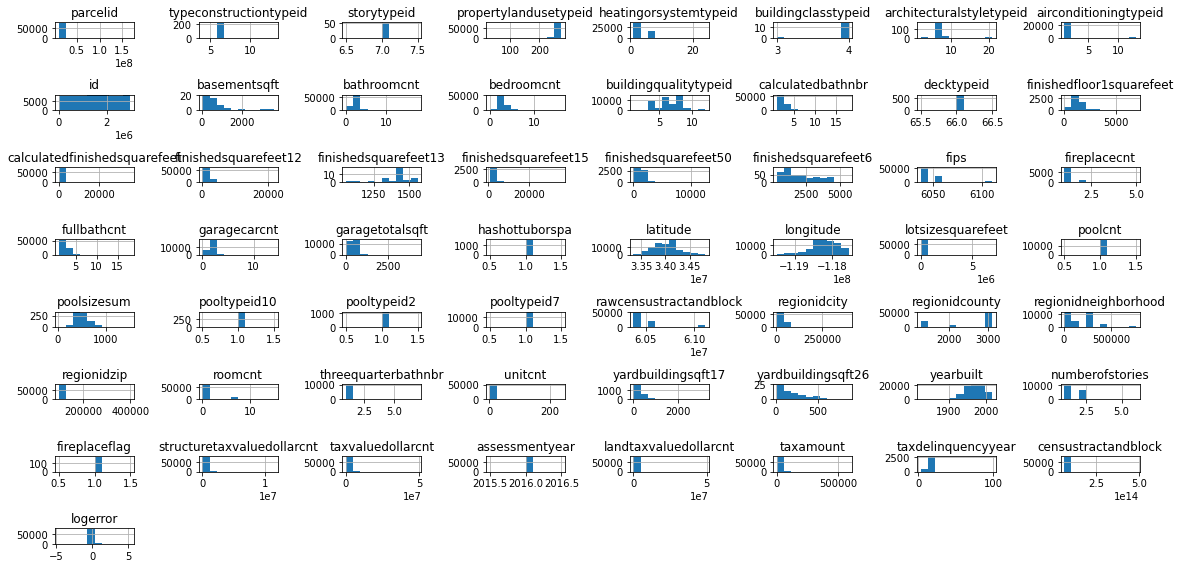

In [7]:
df.hist(figsize=(16, 8))
plt.tight_layout()
plt.show()

3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [8]:
df.parcelid.value_counts(ascending=False)

12086286    1
13842812    1
17089101    1
14604878    1
11149905    1
           ..
13926436    1
10832543    1
11078987    1
11089228    1
14298875    1
Name: parcelid, Length: 77380, dtype: int64

In [9]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    percent_missing = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': percent_missing})
    cols_missing = cols_missing.sort_values(by='percent_rows_missing', ascending=False)
    return cols_missing

In [10]:
nulls_by_col(df)

,num_rows_missing,percent_rows_missing
buildingclassdesc,77365,99.98
buildingclasstypeid,77365,99.98
finishedsquarefeet13,77339,99.95
storytypeid,77330,99.94
storydesc,77330,99.94
...,...,...
rawcensustractandblock,0,0.00
regionidcounty,0,0.00
assessmentyear,0,0.00
roomcnt,0,0.00


4. Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values.

In [11]:
def cols_missing(df):
    num_missing = df.isnull().sum(axis=1)
    percent_missing = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': percent_missing})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'index': 'num_rows'}).reset_index()
    rows_missing = rows_missing.sort_values(by='percent_cols_missing', ascending=False)
    return rows_missing

In [12]:
cols_missing(df)

,num_cols_missing,percent_cols_missing,num_rows
25,48,70.58823529411765,3
24,47,69.11764705882352,3
23,46,67.64705882352942,5
22,45,66.17647058823529,50
21,44,64.70588235294117,78
20,43,63.23529411764706,28
19,42,61.76470588235294,23
18,41,60.29411764705882,29
17,40,58.82352941176471,230
16,39,57.35294117647059,285


## Prepare

1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.

In [13]:
# filter by propertylandusetypeid
df = df[df.propertylandusetypeid.isin([261, 262, 263, 264, 266, 268, 273, 276])]
df.head()

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,nan,nan,261.00,nan,nan,nan,nan,1727539,nan,...,"60,590,630,072,012.00",0.03,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,17052889,nan,nan,261.00,nan,nan,nan,nan,1387261,nan,...,"61,110,010,023,006.00",0.06,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,14186244,nan,nan,261.00,nan,nan,nan,nan,11677,nan,...,"60,590,218,022,012.00",0.01,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,12177905,nan,nan,261.00,2.00,nan,nan,nan,2288172,nan,...,"60,373,001,001,006.00",-0.10,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,10887214,nan,nan,266.00,2.00,nan,nan,1.00,1970746,nan,...,"60,371,236,012,000.00",0.01,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [14]:
df.shape

(71693, 68)

In [15]:
def remove_outliers(df, col_list, k=1.5):
    for col in col_list:
        
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
    
        upper_bound = q3 + k * iqr
        lower_bound = q1 - k * iqr
    
        df = df[df[col] > lower_bound]
        df = df[df[col] < upper_bound]
    
    return df

In [16]:
# remove outliers
df = remove_outliers(df, ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'], k=1.5)

In [17]:
df.shape

(66620, 68)

2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

The input:
- A dataframe
- A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
- A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).

The output:
- The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.

hint:
- Look up the dropna documentation.
- You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
- Make use of inplace, i.e. inplace=True/False.

In [18]:
def handle_missing_values(df, prop_required_column=0.5, prop_required_row=0.75):
    col_threshold = int(round(prop_required_column * df.shape[0],0))
    df.dropna(axis=1, thresh=col_threshold, inplace=True)
    row_threshold = int(round(prop_required_row * df.shape[1],0))
    df.dropna(axis=0, thresh=row_threshold, inplace=True)
    return df

In [19]:
df = handle_missing_values(df)
df.shape

(66619, 34)

In [20]:
df.isnull().sum()

parcelid                            0
propertylandusetypeid               0
heatingorsystemtypeid           22755
id                                  0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           24241
calculatedbathnbr                  14
calculatedfinishedsquarefeet        0
finishedsquarefeet12              168
fips                                0
fullbathcnt                        14
latitude                            0
longitude                           0
lotsizesquarefeet                7905
propertycountylandusecode           0
propertyzoningdesc              23951
rawcensustractandblock              0
regionidcity                     1113
regionidcounty                      0
regionidzip                        31
roomcnt                             0
unitcnt                         23969
yearbuilt                          24
structuretaxvaluedollarcnt         63
taxvaluedollarcnt                   1
assessmentye

In [21]:
# drop redundant and unneeded columns
df = df.drop(columns=['propertylandusetypeid', 'heatingorsystemtypeid', 'id', 'calculatedbathnbr', 'finishedsquarefeet12',\
                      'fullbathcnt', 'propertycountylandusecode', 'propertyzoningdesc', 'censustractandblock'])

In [22]:
df.shape

(66619, 25)

3. Decide how to handle the remaining missing values:

- Fill with constant value.
- Impute with mean, median, mode.
- Drop row/column

In [24]:
df.isnull().sum().sort_values(ascending=False)

buildingqualitytypeid           24241
unitcnt                         23969
heatingorsystemdesc             22755
lotsizesquarefeet                7905
regionidcity                     1113
structuretaxvaluedollarcnt         63
regionidzip                        31
yearbuilt                          24
taxamount                           5
landtaxvaluedollarcnt               1
taxvaluedollarcnt                   1
longitude                           0
calculatedfinishedsquarefeet        0
bedroomcnt                          0
fips                                0
bathroomcnt                         0
latitude                            0
propertylandusedesc                 0
rawcensustractandblock              0
regionidcounty                      0
roomcnt                             0
assessmentyear                      0
logerror                            0
transactiondate                     0
parcelid                            0
dtype: int64

In [25]:
# going to drop buildingqualitytypeid and heatingorsystemdesc - changing the value would cause huge impact
df = df.drop(columns=['buildingqualitytypeid', 'unitcnt', 'heatingorsystemdesc'])

In [26]:
df.shape

(66619, 22)

In [27]:
df.isnull().sum()[df.isnull().sum() > 0]

lotsizesquarefeet             7905
regionidcity                  1113
regionidzip                     31
yearbuilt                       24
structuretaxvaluedollarcnt      63
taxvaluedollarcnt                1
landtaxvaluedollarcnt            1
taxamount                        5
dtype: int64

In [28]:
def impute(df, method, col_list):
    
    imputer = SimpleImputer(strategy=method)
    
    df[col_list] = imputer.fit_transform(df[col_list])
    
    return df

In [29]:
# determine list to replace with 'median' values
median_impute = ['lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',\
                 'landtaxvaluedollarcnt', 'taxamount']

In [30]:
df = impute(df, 'median', median_impute)

In [31]:
df.isnull().sum()[df.isnull().sum() > 0]

regionidcity    1113
regionidzip       31
yearbuilt         24
dtype: int64

In [32]:
# set up list to replace with 'most_frequent' values
mf_impute = ['regionidcity', 'regionidzip', 'yearbuilt']

In [33]:
df = impute(df, 'most_frequent', mf_impute)

In [34]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

In [35]:
df.shape

(66619, 22)